In [6]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import pickle
from num2words import num2words
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_pickle('/work/data_pipeline/audio_data/preprocessing/web_free_source_raw/OpenSLR/SLR101/meta_metrics.pkl').dropna()
df = df[['filepath', 'gender', 'age']]
display(df)

,filepath,gender,age
0,/work/data_pipeline/audio_data/preprocessing/w...,m,7
1,/work/data_pipeline/audio_data/preprocessing/w...,f,30
2,/work/data_pipeline/audio_data/preprocessing/w...,f,21
3,/work/data_pipeline/audio_data/preprocessing/w...,m,9
4,/work/data_pipeline/audio_data/preprocessing/w...,m,10
...,...,...,...
5239,/work/data_pipeline/audio_data/preprocessing/w...,m,6
5241,/work/data_pipeline/audio_data/preprocessing/w...,f,21
5242,/work/data_pipeline/audio_data/preprocessing/w...,m,9
5243,/work/data_pipeline/audio_data/preprocessing/w...,f,21


In [7]:
df['age'] = pd.to_numeric(df['age'])
df = df.sort_values('age')
classes = df['age'].unique()
print(classes)

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'The speakers age is '
y = [prompt + num2words(str(x)) for x in classes]
print(y)


[ 6  7  8  9 10 11 12 13 14 15 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 35 37 38 43]
{6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 19: 10, 20: 11, 21: 12, 22: 13, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 19, 29: 20, 30: 21, 31: 22, 32: 23, 33: 24, 35: 25, 37: 26, 38: 27, 43: 28}
['The speakers age is six', 'The speakers age is seven', 'The speakers age is eight', 'The speakers age is nine', 'The speakers age is ten', 'The speakers age is eleven', 'The speakers age is twelve', 'The speakers age is thirteen', 'The speakers age is fourteen', 'The speakers age is fifteen', 'The speakers age is nineteen', 'The speakers age is twenty', 'The speakers age is twenty-one', 'The speakers age is twenty-two', 'The speakers age is twenty-three', 'The speakers age is twenty-four', 'The speakers age is twenty-five', 'The speakers age is twenty-six', 'The speakers age is twenty-seven', 'The speakers age is twenty-eight', 'The speakers age is twenty-nine', 'The speakers age 

In [8]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)# Load and initialize CLAP

# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df))):
    path, gender, age = df.iloc[i]
    idx = class_id_map[age]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())

y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 4999/4999 [09:59<00:00,  8.33it/s]

Accuracy 0.017803560712142428


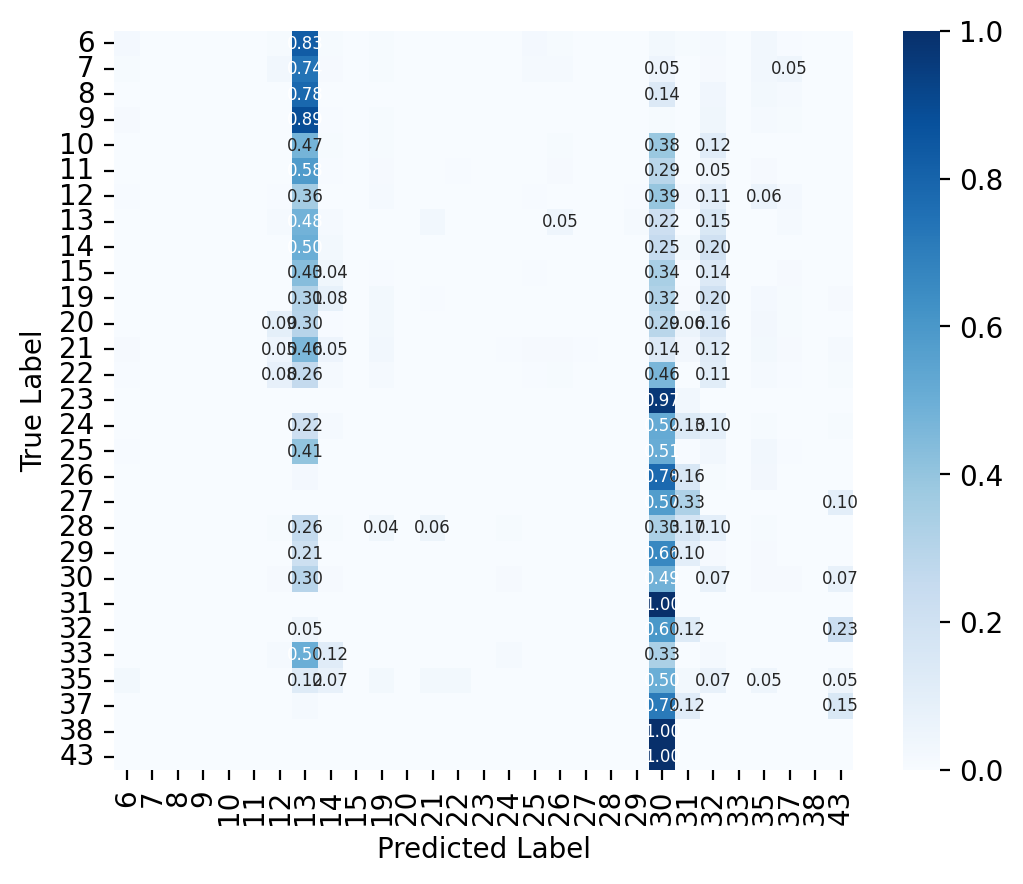

In [10]:
# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()